In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

In [2]:
# Reading the data
path = '../input/skin-cancer-mnist-ham10000/'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}

In [3]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
    
}

In [4]:
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')


In [5]:
# Adding extra columns and appending the required created columns in final dataframe
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [6]:
# Image Reading and Resizing.
IMAGE_SIZE = 32
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 10015/10015 [02:46<00:00, 60.03it/s]


In [7]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
X=X[1:]
print(X.shape)
y = np.array(skin_df['cell_type_idx'])
y=y[1:]

(10014, 32, 32, 3)


In [8]:
# Splitting the data
from sklearn.model_selection import train_test_split

train_df ,test_df,train_labl ,test_labl = train_test_split(X,y,test_size=0.2,random_state=42)



In [9]:
test_labl.shape

(2003,)

In [10]:
train_labl.shape

(8011,)

In [11]:
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(32,32,3)),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=4, max_value=128, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),

    
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=4, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(7, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-5])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [12]:
#importing random search
from kerastuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5)
# search best parameter
tuner.search(train_df,train_labl,epochs=3,validation_data=(test_df,test_labl))

Trial 5 Complete [00h 04m 32s]
val_accuracy: 0.6630054712295532

Best val_accuracy So Far: 0.6630054712295532
Total elapsed time: 00h 13m 59s


In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 1e-05], 'ordered': True}


In [14]:
model=tuner.get_best_models(num_models=1)[0]
#summary of best model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 96)        27744     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 96)        83040     
_________________________________________________________________
flatten (Flatten)            (None, 55296)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 221188    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 35        
Total params: 334,439
Trainable params: 334,439
Non-trainable params: 0
__________________________________________________

In [15]:
from keras.utils.vis_utils import plot_model

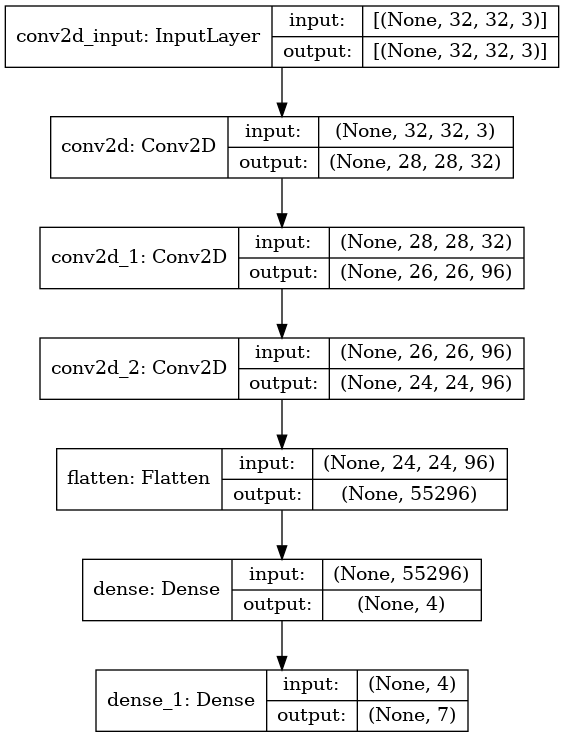

In [16]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 32
conv_1_kernel: 5
conv_2_filter: 96
conv_2_kernel: 3
dense_1_units: 4
learning_rate: 0.1
Score: 0.6630054712295532
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 3
conv_2_filter: 80
conv_2_kernel: 3
dense_1_units: 52
learning_rate: 0.1
Score: 0.6630054712295532
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernel: 3
conv_2_filter: 48
conv_2_kernel: 5
dense_1_units: 36
learning_rate: 1e-05
Score: 0.6630054712295532
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 3
conv_2_filter: 80
conv_2_kernel: 3
dense_1_units: 116
learning_rate: 1e-05
Score: 0.6630054712295532
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 3
conv_2_filter: 112
conv_2_kernel: 3
dense_1_units: 68
learning_rate: 0.1
Score: 0.6630054712295532


In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4,mode='max', verbose=1)

In [19]:
history=model.fit(train_df,train_labl,
          epochs=200,
          validation_split=0.2, callbacks=[callback])

Epoch 1/200
201/201 [==============================] - 29s 140ms/step - loss: 1.1350 - accuracy: 0.6712 - val_loss: 1.1265 - val_accuracy: 0.6712
Epoch 2/200
201/201 [==============================] - 28s 141ms/step - loss: 1.1365 - accuracy: 0.6712 - val_loss: 1.1198 - val_accuracy: 0.6712
Epoch 3/200
201/201 [==============================] - 28s 140ms/step - loss: 1.1342 - accuracy: 0.6712 - val_loss: 1.1312 - val_accuracy: 0.6712
Epoch 4/200
201/201 [==============================] - 28s 141ms/step - loss: 1.1350 - accuracy: 0.6712 - val_loss: 1.1261 - val_accuracy: 0.6712
Epoch 5/200
201/201 [==============================] - 28s 140ms/step - loss: 1.1367 - accuracy: 0.6712 - val_loss: 1.1201 - val_accuracy: 0.6712
Epoch 00005: early stopping


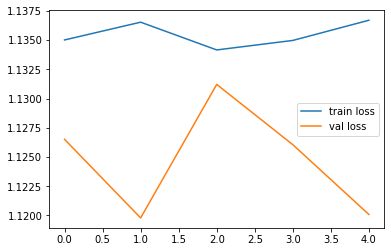

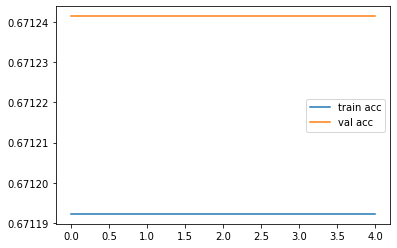

In [20]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [21]:
pred = model.predict(test_df)
pred = np.argmax(pred,axis=1)


In [22]:
from sklearn.metrics import classification_report

print(classification_report(test_labl,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00       228
           3       0.00      0.00      0.00        28
           4       0.66      1.00      0.80      1328
           5       0.00      0.00      0.00       226
           6       0.00      0.00      0.00        22

    accuracy                           0.66      2003
   macro avg       0.09      0.14      0.11      2003
weighted avg       0.44      0.66      0.53      2003



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
